In [6]:
import pywt
from scipy.signal import convolve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

np.set_printoptions(threshold=np.inf)

In [7]:
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')


In [8]:
def hampel_filter(data, window_size=7, n_sigmas=3):
    n = len(data)
    new_data = data.copy()
    k = 1.4826  # scale factor for Gaussian distribution
    indices = []

    for i in range((window_size//2), (n - window_size//2)):
        window = data[(i - window_size//2):(i + window_size//2)]
        median = np.median(window)
        diff = np.abs(window - median)
        median_abs_deviation = np.median(diff)
        threshold = n_sigmas * k * median_abs_deviation

        if np.abs(data[i] - median) > threshold:
            new_data[i] = median  # replace with median
            indices.append(i)  # index of outlier

    return new_data, indices

In [4]:
def visualize(path1):
    # Data import
    data = pd.read_csv(path1)
    amp = data.iloc[:, 1:65].values

    # plt
    fig = plt.figure(figsize=(18, 10))
    ax1 = plt.subplot(311)
    plt.imshow(amp[:, 0:21].T, interpolation="nearest",
               aspect="auto", cmap="jet")
    ax1.set_title("Antenna1 Amplitude")
    plt.colorbar()

    ax2 = plt.subplot(312)
    plt.imshow(amp[:, 21:43].T, interpolation="nearest",
               aspect="auto", cmap="jet")
    ax2.set_title("Antenna2 Amplitude")
    plt.colorbar()

    ax3 = plt.subplot(313)
    plt.imshow(amp[:, 43:65].T, interpolation="nearest",
               aspect="auto", cmap="jet")
    ax3.set_title("Antenna3 Amplitude")
    plt.colorbar()
    plt.show()

    # Initializing variables
    constant_offset = np.empty_like(amp)
    filtered_data = np.empty_like(amp)

    # Calculating the constant offset (moving average 4 seconds)
    for i in range(amp.shape[1]):
        constant_offset[:, i] = moving_average(amp[:, i], 4000)

    # Calculating the filtered data (subtract the constant offset)
    filtered_data = amp - constant_offset

    # Smoothing (moving average 0.01 seconds)
    for i in range(filtered_data.shape[1]):
        filtered_data[:, i] = moving_average(filtered_data[:, i], 10)

    # Calculate correlation matrix (64 * 64 dim)
    cov_mat2 = np.cov(filtered_data.T)

    # Calculate eig_val & eig_vec
    eig_val2, eig_vec2 = np.linalg.eig(cov_mat2)

    # Sort the eig_val & eig_vec
    idx = eig_val2.argsort()[::-1]
    eig_val2 = eig_val2[idx]
    eig_vec2 = eig_vec2[:, idx]

    # Calculate H * eig_vec
    pca_data2 = filtered_data.dot(eig_vec2)

    xmin = 0
    xmax = 20000

    # plt
    fig3 = plt.figure(figsize=(18, 20))

    ax1 = plt.subplot(611)
    plt.plot(pca_data2[xmin:xmax, 0])
    ax1.set_title("PCA 1st component")

    ax2 = plt.subplot(612)
    plt.plot(pca_data2[xmin:xmax, 1])
    ax2.set_title("PCA 2nd component")

    ax3 = plt.subplot(613)
    plt.plot(pca_data2[xmin:xmax, 2])
    ax3.set_title("PCA 3rd component")

    ax4 = plt.subplot(614)
    plt.plot(pca_data2[xmin:xmax, 3])
    ax4.set_title("PCA 4th component")

    ax5 = plt.subplot(615)
    plt.plot(pca_data2[xmin:xmax, 4])
    ax5.set_title("PCA 5th component")

    ax6 = plt.subplot(616)
    plt.plot(pca_data2[xmin:xmax, 5])
    ax6.set_title("PCA 6th component")

    plt.show()

    # Apply Wavelet Decomposition
    coeffs = pywt.wavedec(pca_data2[:, 0], 'db4', level=5)
    cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Apply Hampel Filter
    filtered_pca_data2 = np.copy(pca_data2)
    for i in range(filtered_pca_data2.shape[1]):
        filtered_pca_data2[:, i], _ = hampel_filter(
            filtered_pca_data2[:, i], window_size=7, n_sigmas=3)

    # Save the final output
    input_dir = os.path.dirname(path1)
    output_path = os.path.join(input_dir, 'final_output.csv')
    output_df = pd.DataFrame(filtered_pca_data2, columns=[
                             f'PCA_{i+1}' for i in range(filtered_pca_data2.shape[1])])
    output_df.to_csv(output_path, index=False)

    plt.figure(figsize=(18, 30))
    # Spectrogram(STFT)
    plt.subplot(611)
    Pxx, freqs, bins, im = plt.specgram(
        filtered_pca_data2[:, 0], NFFT=128, Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT)")
    plt.colorbar(im)
    plt.xlim(0, 10)
    plt.ylim(0, 100)

    plt.subplot(612)
    Pxx, freqs, bins, im = plt.specgram(
        filtered_pca_data2[:, 1], NFFT=128, Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT)")
    plt.colorbar(im)
    plt.xlim(0, 10)
    plt.ylim(0, 100)

    plt.subplot(613)
    Pxx, freqs, bins, im = plt.specgram(
        filtered_pca_data2[:, 2], NFFT=128, Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT)")
    plt.colorbar(im)
    plt.xlim(0, 10)
    plt.ylim(0, 100)

    plt.subplot(614)
    Pxx, freqs, bins, im = plt.specgram(
        filtered_pca_data2[:, 3], NFFT=128, Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT)")
    plt.colorbar(im)
    plt.xlim(0, 10)
    plt.ylim(0, 100)

    plt.subplot(615)
    Pxx, freqs, bins, im = plt.specgram(
        filtered_pca_data2[:, 4], NFFT=128, Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT)")
    plt.colorbar(im)
    plt.xlim(0, 10)
    plt.ylim(0, 100)

    plt.subplot(616)
    Pxx, freqs, bins, im = plt.specgram(
        filtered_pca_data2[:, 5], NFFT=128, Fs=1000, noverlap=1, cmap="jet", vmin=-100, vmax=20)
    plt.xlabel("Time[s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram(STFT)")
    plt.colorbar(im)
    plt.xlim(0, 10)
    plt.ylim(0, 100)

    plt.show()

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    ax.magnitude_spectrum(
        filtered_pca_data2[5000:7500, 0], Fs=1000, color='C1')
    plt.xlim(0, 100)
    plt.ylim(0, 1000)
    plt.show()



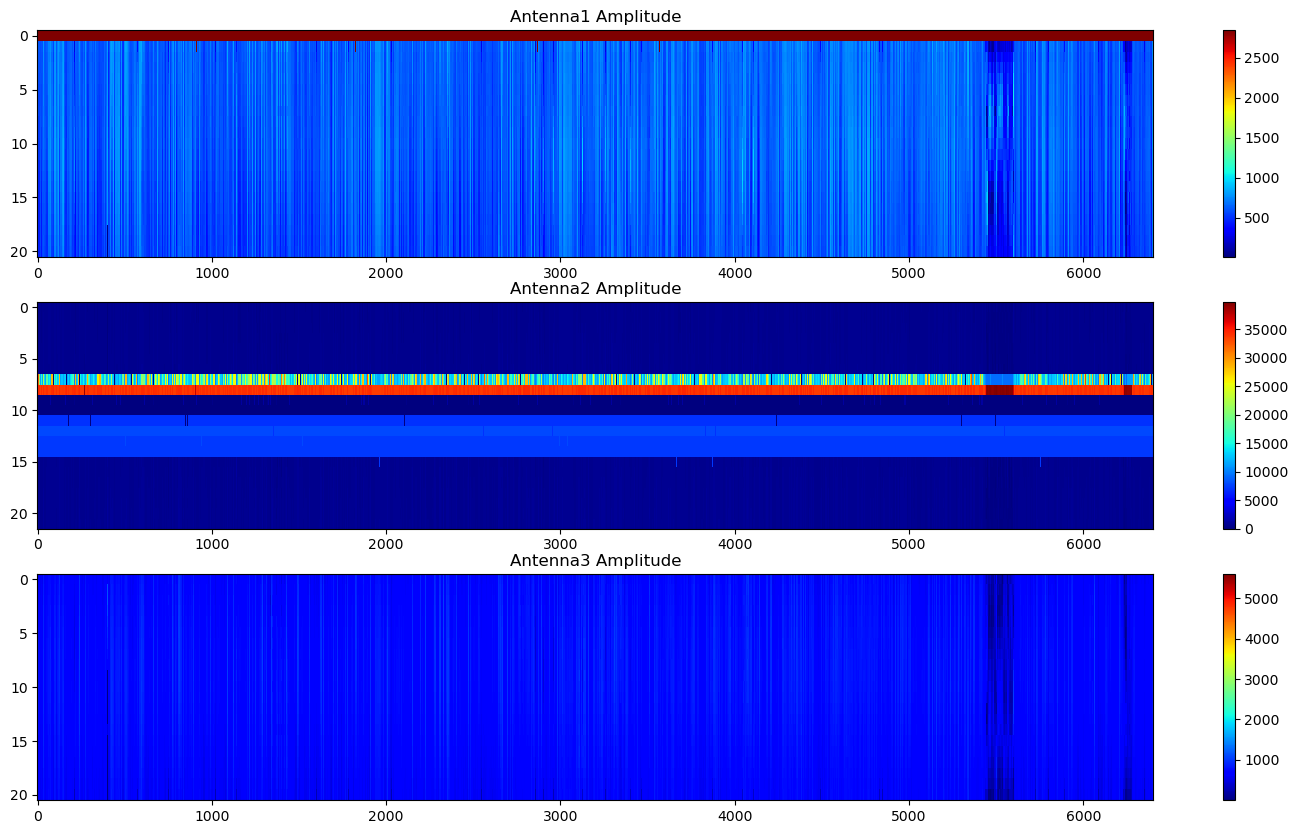

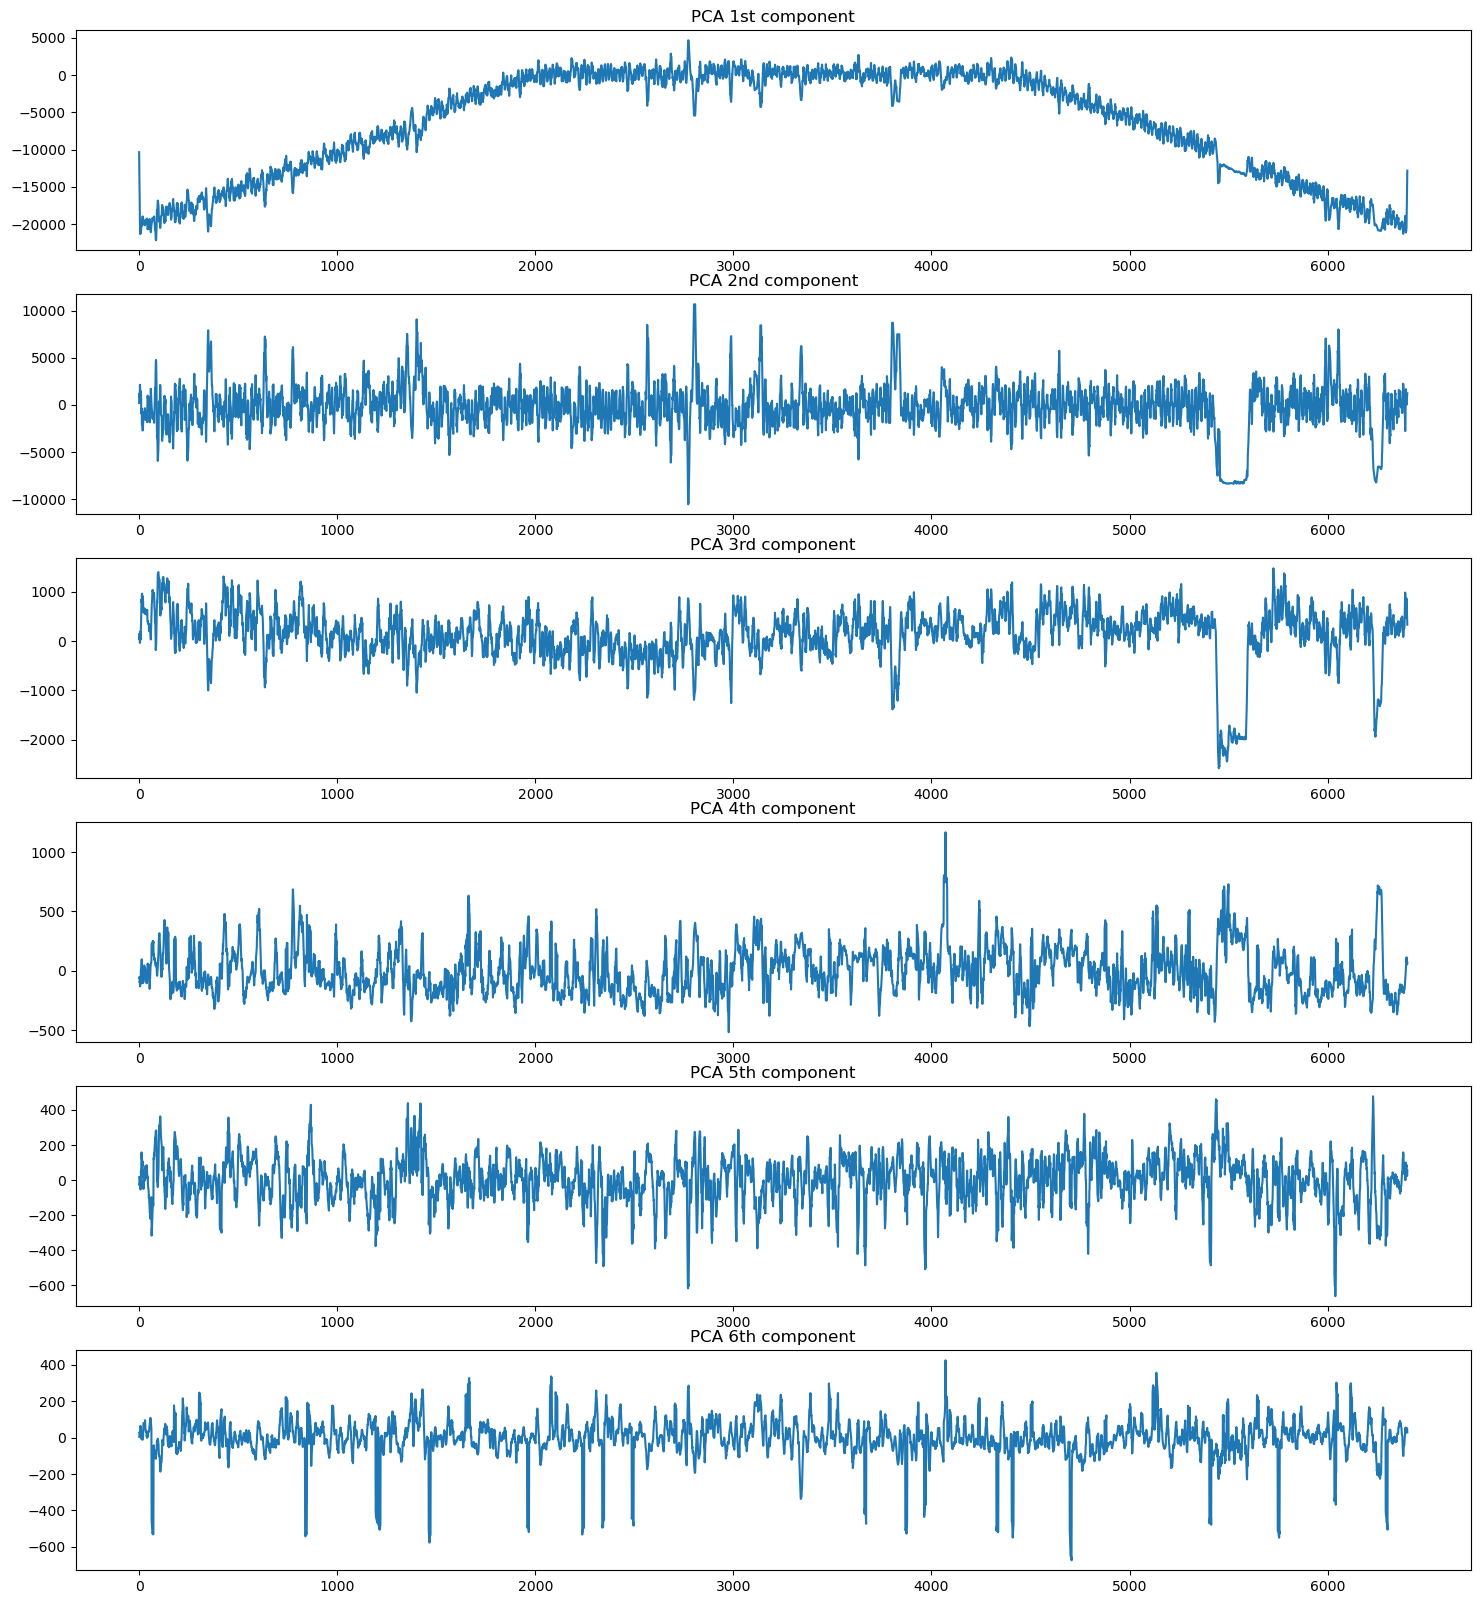

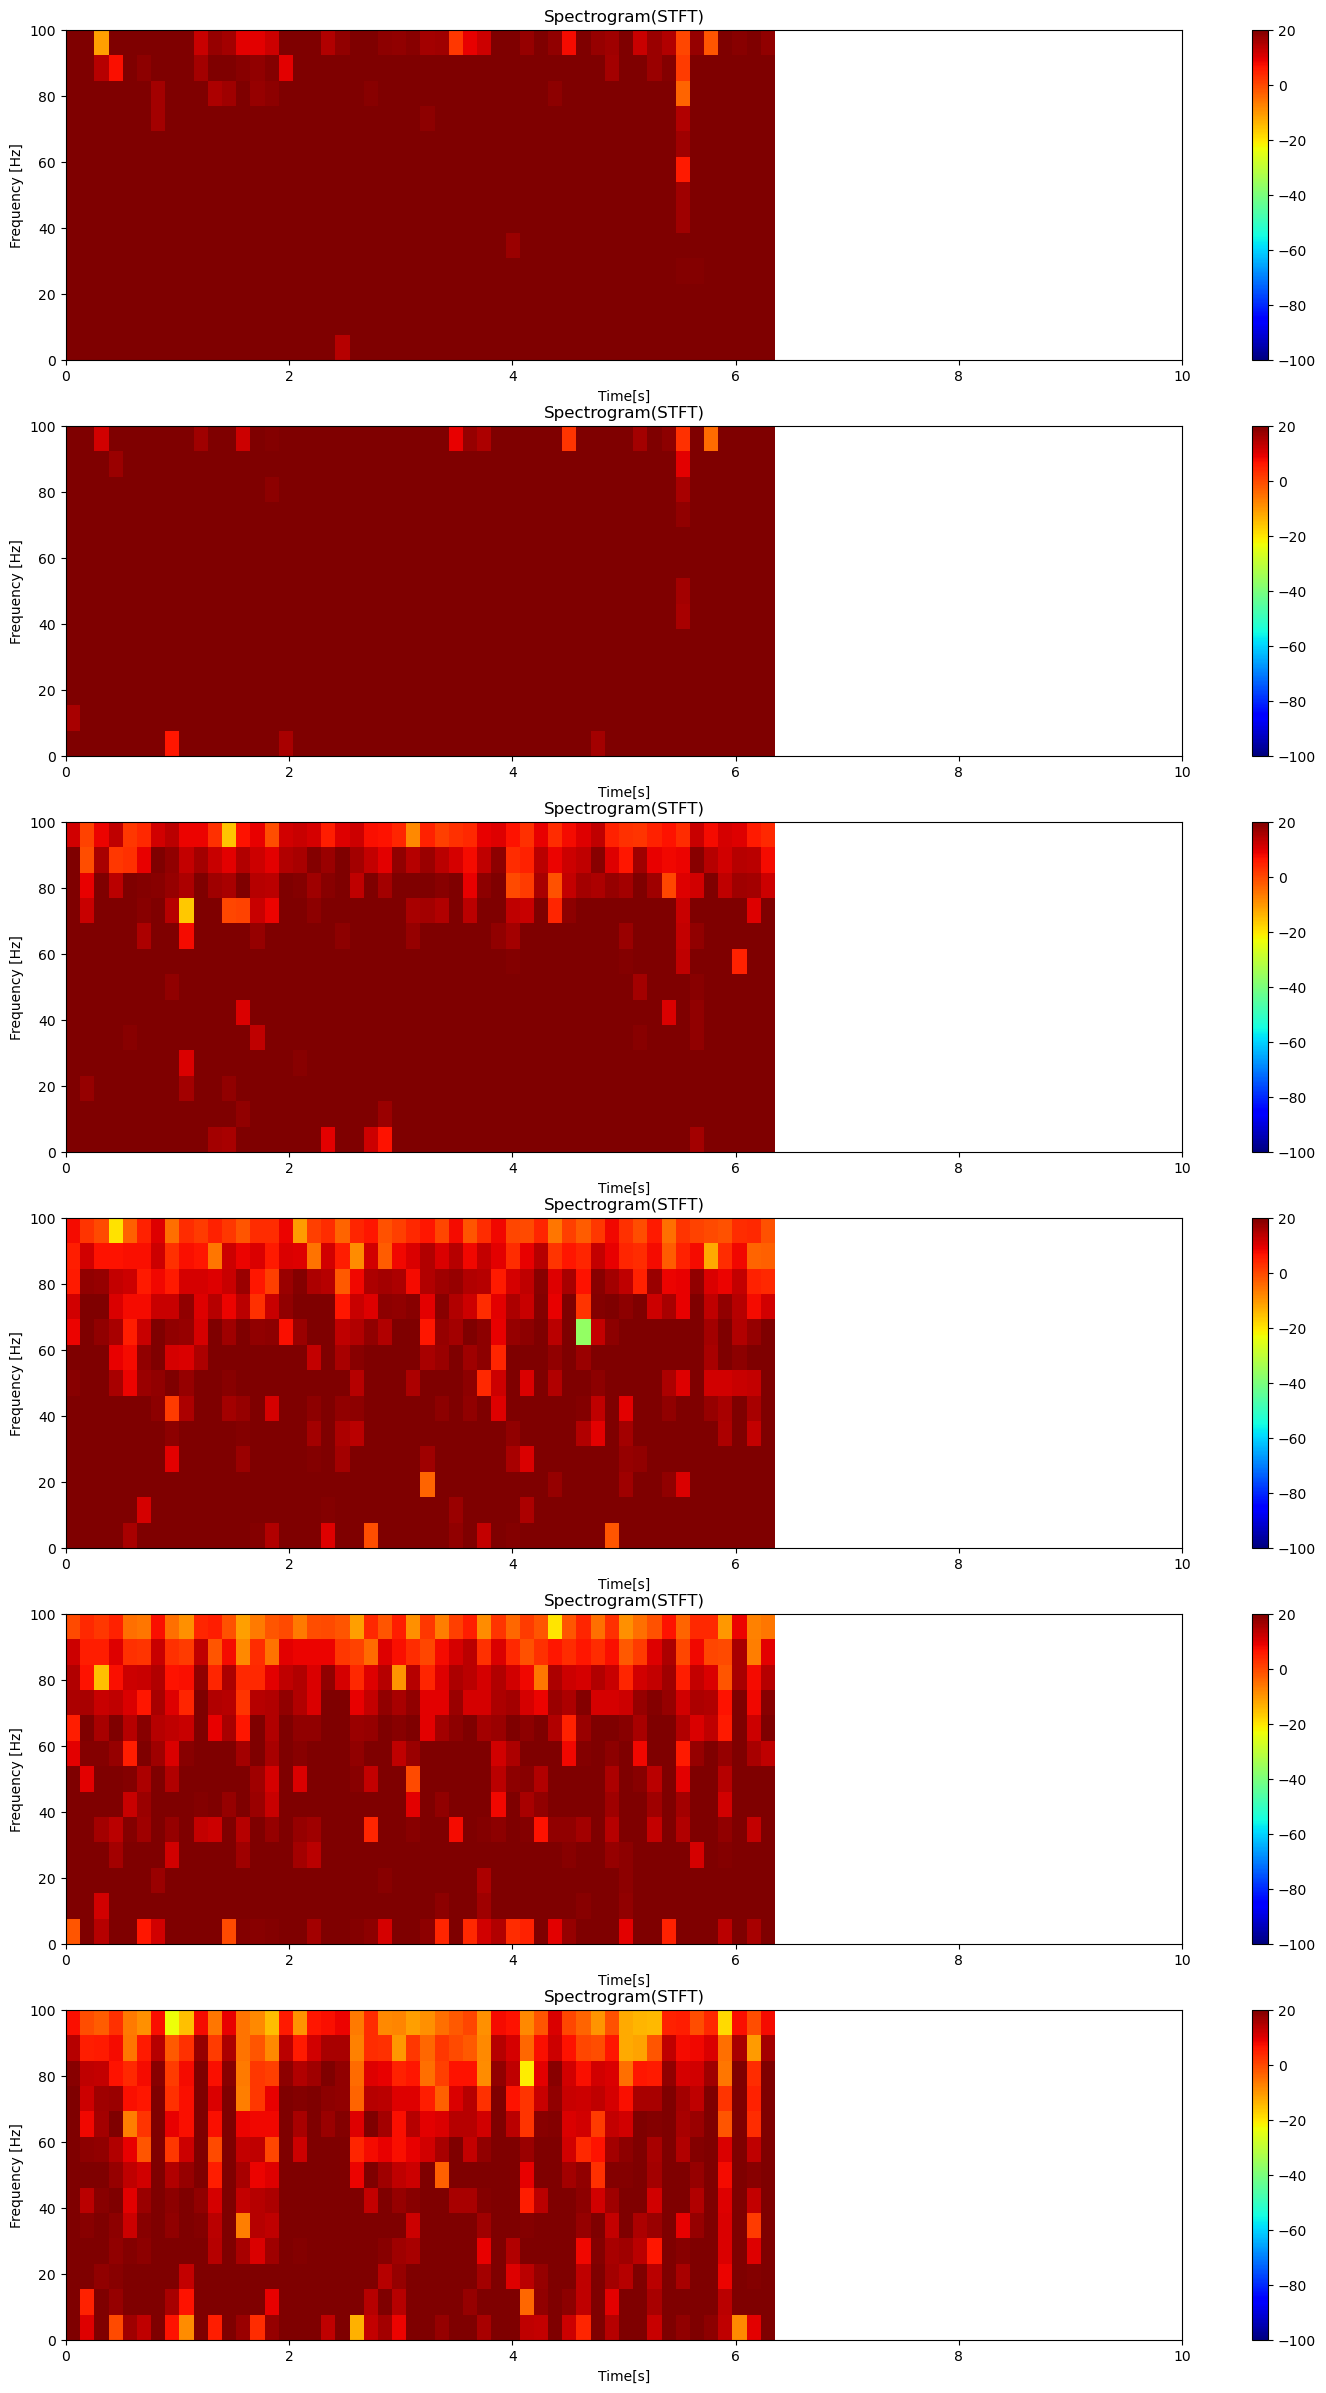

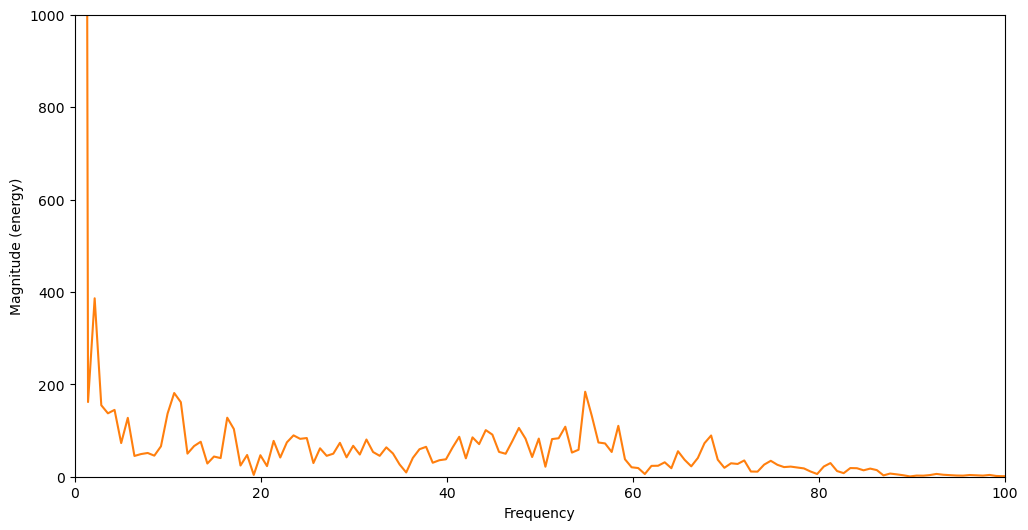

In [5]:
# Use the function with the provided CSV file
visualize('//Users/psubedi/Downloads/Major/preprocessing/format_converted/transformed_throughrun.csv')